The data was gather from [Aung Pyae's Kaggle](https://www.kaggle.com/aungpyaeap/supermarket-sales)

# 1. Load the data.

In [1]:
from settings import *

import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

import seaborn as sns
from sqlalchemy import create_engine

We need to create an engine in order to connect to a SQL data base.

In [2]:
engine = create_engine(f"{dialect}://{user}{passwd}@{host}:{port}/{db}")

Let's define a little function to avoid typing excessively.

In [3]:
def query(query: str):
    return pd.read_sql_query(query, engine)

Let's try our connection in a simple query.

In [4]:
query("SELECT * FROM supermarket LIMIT 2")

,id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,purchase_date,time,payment,cogs,gross_margin_perct,gross_income,rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08:00,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29:00,Cash,76.40,4.761905,3.8200,9.6


In [5]:
query("""
      SELECT
      DISTINCT COUNT(*) OVER () AS table_length
      FROM supermarket
      """)

,table_length
0,1000


# 2. Exploratory Data Analysis

## 2.1 Data Quality

In this first part we'll check what kind of dataypes we're working with, see if there are null or duplicate values.

First, we'll check the data types in the table.

In [6]:
query("""
      SELECT
      column_name
      , data_type
      , is_nullable
      FROM INFORMATION_SCHEMA.COLUMNS
      WHERE table_name = 'supermarket'
      """)

,column_name,data_type,is_nullable
0,id,character,NO
1,branch,character,NO
2,city,character varying,NO
3,customer_type,character varying,YES
4,gender,character varying,YES
5,product_line,character varying,NO
6,unit_price,numeric,NO
7,quantity,integer,NO
8,tax_5,numeric,NO
9,total,numeric,NO


Everything seems to be ok. No column appears to have an inconvinient type and most of them are not-nullable, meaning they can't hold nullable values and we don't have to worry about it, except for customer_type and gender. Let's check the existence and amount of null values, if any.

In [7]:
query("""
      SELECT
      customer_type
      , gender
      FROM supermarket
      WHERE customer_type IS NULL
          OR gender IS NULL;
      """)

,customer_type,gender


We don't have any null values. Great! 

Now let's confirm that the data given by the variable ***total*** is **equal** to unit_price by quantity plus tax_5 or


$ total = unit\_price * quantity + tax\_5 $ 

In [8]:
query("""
      SELECT
      COUNT(*)
      FROM supermarket
      WHERE total != unit_price * quantity + tax_5
      """)

,count
0,0


It seems the total is well calculated.

Now, let's see if there are any duplicate records. In this instance we'll define a dupe as a row that shares all the values of another row, except for the id.

In [9]:
query("""
      SELECT
      COUNT(*) AS dupes
      FROM supermarket
      GROUP BY
      branch
        , city
        , customer_type
        , gender
        , product_line
        , unit_price
        , quantity
        , tax_5
        , total
        , purchase_date
        , time
        , payment
        , cogs
        , gross_margin_perct
        , gross_income
        , rating
      HAVING COUNT(*) > 1
      
      """)

,dupes


It seems we don't have any dupes as we have defined them.

## 2.2 Feature profiling

Now let's revise each of the variables individually, frequencies (if categorical) or distribution (if numerical).

### 2.2.1 Branch

The first variable is branch, it is categorical, so we have to check what they are and how frequent they are.

In [10]:
query("""
      SELECT
      branch
      , COUNT(*)
      FROM supermarket
      GROUP BY branch
      """)

,branch,count
0,A,340
1,B,332
2,C,328


<AxesSubplot:xlabel='branch', ylabel='count'>

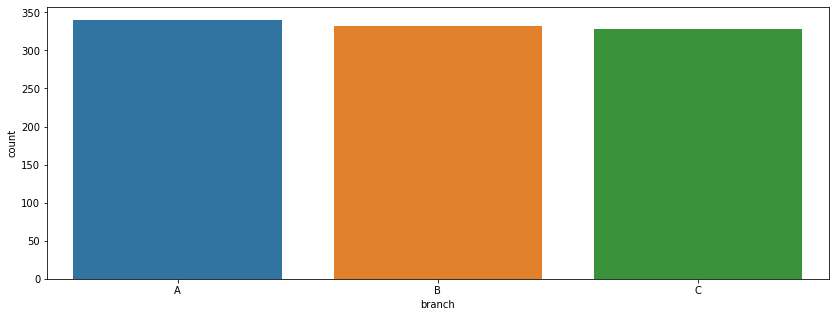

In [11]:
plt.figure(figsize=(14,5))
sns.barplot(x="branch", y="count", data=query("""
                                              SELECT
                                              branch
                                              , COUNT(*)
                                              FROM supermarket
                                              GROUP BY branch
                                              """).sort_values("count", ascending=False))

### 2.2.2 City

In [12]:
query("""
      SELECT
      city
      , COUNT(*)
      FROM supermarket
      GROUP BY city
      """)

,city,count
0,Yangon,340
1,Naypyitaw,328
2,Mandalay,332


<AxesSubplot:xlabel='city', ylabel='count'>

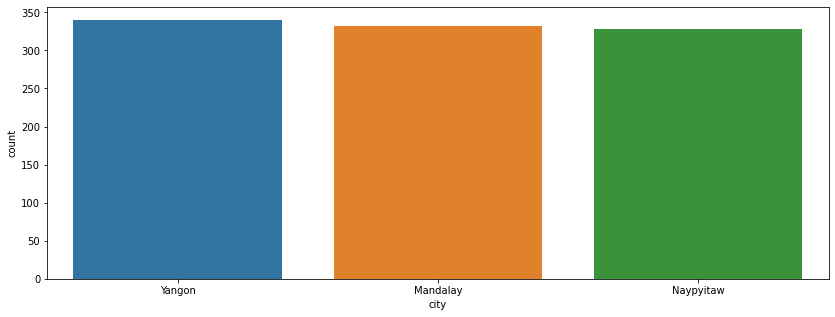

In [13]:
plt.figure(figsize=(14,5))
sns.barplot(x="city", y="count", data=query("""
                                              SELECT
                                              city
                                              , COUNT(*)
                                              FROM supermarket
                                              GROUP BY city
                                              """).sort_values("count", ascending=False))

### 2.2.3 Gender

In [14]:
query("""
      SELECT
      gender
      , COUNT(*)
      FROM supermarket
      GROUP BY gender
      """)

,gender,count
0,Female,501
1,Male,499


<AxesSubplot:xlabel='gender', ylabel='count'>

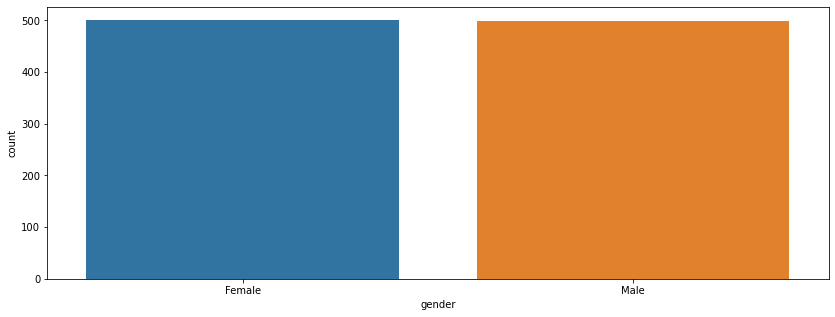

In [15]:
plt.figure(figsize=(14,5))
sns.barplot(x="gender", y="count", data=query("""
                                              SELECT
                                              gender
                                              , COUNT(*)
                                              FROM supermarket
                                              GROUP BY gender
                                              """).sort_values("count", ascending=False))

### 2.2.4 Product line

In [16]:
query("""
      SELECT
      product_line
      , COUNT(*)
      FROM supermarket
      GROUP BY product_line
      """)

,product_line,count
0,Fashion accessories,178
1,Electronic accessories,170
2,Health and beauty,152
3,Food and beverages,174
4,Sports and travel,166
5,Home and lifestyle,160


<AxesSubplot:xlabel='product_line', ylabel='count'>

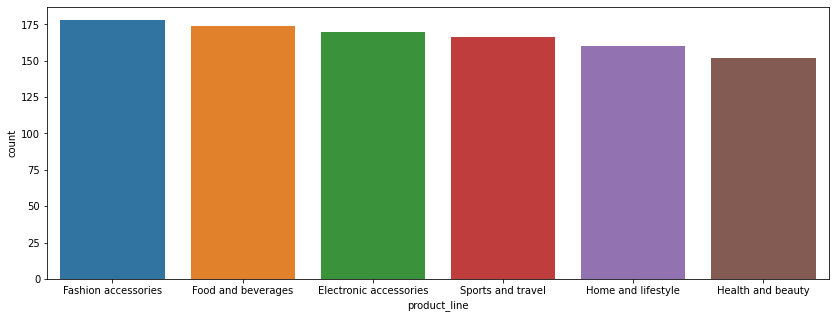

In [17]:
plt.figure(figsize=(14,5))
sns.barplot(x="product_line", y="count", data=query("""
                                              SELECT
                                              product_line
                                              , COUNT(*)
                                              FROM supermarket
                                              GROUP BY product_line
                                              """).sort_values("count", ascending=False))

### 2.2.5 Payment type

In [18]:
query("""
      SELECT
      payment
      , COUNT(*)
      FROM supermarket
      GROUP BY payment
      """)

,payment,count
0,Credit card,311
1,Ewallet,345
2,Cash,344


<AxesSubplot:xlabel='payment', ylabel='count'>

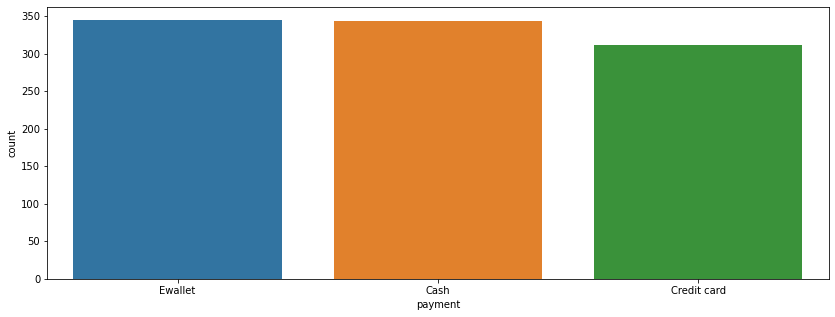

In [19]:
plt.figure(figsize=(14,5))
sns.barplot(x="payment", y="count", data=query("""
                                              SELECT
                                              payment
                                              , COUNT(*)
                                              FROM supermarket
                                              GROUP BY payment
                                              """).sort_values("count", ascending=False))

### 2.2.6 Customer type

In [20]:
query("""
      SELECT
      customer_type
      , COUNT(*)
      FROM supermarket
      GROUP BY customer_type
      
      """)

,customer_type,count
0,Normal,499
1,Member,501


<AxesSubplot:xlabel='customer_type', ylabel='count'>

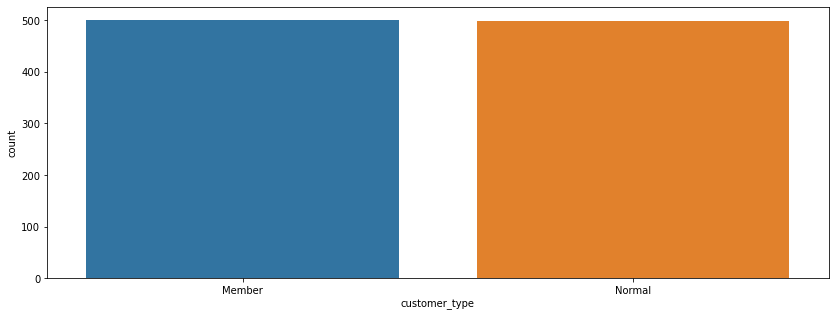

In [21]:
plt.figure(figsize=(14,5))
sns.barplot(x="customer_type", y="count", data=query("""
                                              SELECT
                                              customer_type
                                              , COUNT(*)
                                              FROM supermarket
                                              GROUP BY customer_type
                                              """).sort_values("count", ascending=False))

In [22]:
query("""
      SELECT
      COUNT(*) AS dupes
      FROM supermarket
      GROUP BY
      branch
        , city
        , customer_type
        , gender
        , product_line
        , unit_price
        , quantity
        , tax_5
        , total
        , purchase_date
        , time
        , payment
        , cogs
        , gross_margin_perct
        , gross_income
        , rating
      HAVING COUNT(*) > 1
      
      """)

,dupes


### 2.2.7 Numerical variables

In [61]:
query("""
    SELECT
    'average'
    """)

,?column?
0,average


In [79]:
query("""
      SELECT
      'average' AS metric
      , AVG(unit_price) AS unit_price
      , AVG(quantity) AS quantity
      , AVG(total) AS total
      , AVG(cogs) AS cogs
      , AVG(gross_margin_perct) AS gross_margin_perct
      , AVG(gross_income) AS gross_income
      , AVG(rating) AS rating
      FROM supermarket
      
      UNION ALL
      SELECT
      'stdev' AS metric
      , STDDEV(unit_price) AS unit_price
      , STDDEV(quantity) AS quantity
      , STDDEV(total) AS total
      , STDDEV(cogs) AS cogs
      , STDDEV(gross_margin_perct) AS gross_margin_perct
      , STDDEV(gross_income) AS gross_income
      , STDDEV(rating) AS rating
      FROM supermarket
      
      UNION ALL
      SELECT
      'min' AS metric
      , MIN(unit_price) AS unit_price
      , MIN(quantity) AS quantity
      , MIN(total) AS total
      , MIN(cogs) AS cogs
      , MIN(gross_margin_perct) AS gross_margin_perct
      , MIN(gross_income) AS gross_income
      , MIN(rating) AS rating
      FROM supermarket
      
      UNION ALL
      SELECT
      '25%%' AS metric
      , percentile_cont(.25) WITHIN GROUP (ORDER BY unit_price) AS unit_price
      , percentile_cont(.25) WITHIN GROUP (ORDER BY quantity) AS quantity
      , percentile_cont(.25) WITHIN GROUP (ORDER BY total) AS total
      , percentile_cont(.25) WITHIN GROUP (ORDER BY cogs) AS cogs
      , percentile_cont(.25) WITHIN GROUP (ORDER BY gross_margin_perct) AS gross_margin_perct
      , percentile_cont(.25) WITHIN GROUP (ORDER BY gross_income) AS gross_income
      , percentile_cont(.25) WITHIN GROUP (ORDER BY rating) AS rating
      FROM supermarket
      
      UNION ALL
      SELECT
      'median' AS metric
      , percentile_cont(.5) WITHIN GROUP (ORDER BY unit_price) AS unit_price
      , percentile_cont(.5) WITHIN GROUP (ORDER BY quantity) AS quantity
      , percentile_cont(.5) WITHIN GROUP (ORDER BY total) AS total
      , percentile_cont(.5) WITHIN GROUP (ORDER BY cogs) AS cogs
      , percentile_cont(.5) WITHIN GROUP (ORDER BY gross_margin_perct) AS gross_margin_perct
      , percentile_cont(.5) WITHIN GROUP (ORDER BY gross_income) AS gross_income
      , percentile_cont(.5) WITHIN GROUP (ORDER BY rating) AS rating
      FROM supermarket
      
      UNION ALL
      SELECT
      '75%%' AS metric
      , percentile_cont(.75) WITHIN GROUP (ORDER BY unit_price) AS unit_price
      , percentile_cont(.75) WITHIN GROUP (ORDER BY quantity) AS quantity
      , percentile_cont(.75) WITHIN GROUP (ORDER BY total) AS total
      , percentile_cont(.75) WITHIN GROUP (ORDER BY cogs) AS cogs
      , percentile_cont(.75) WITHIN GROUP (ORDER BY gross_margin_perct) AS gross_margin_perct
      , percentile_cont(.75) WITHIN GROUP (ORDER BY gross_income) AS gross_income
      , percentile_cont(.75) WITHIN GROUP (ORDER BY rating) AS rating
      FROM supermarket
         
      UNION ALL
      SELECT
      'max' AS metric
      , MAX(unit_price) AS unit_price
      , MAX(quantity) AS quantity
      , MAX(total) AS total
      , MAX(cogs) AS cogs
      , MAX(gross_margin_perct) AS gross_margin_perct
      , MAX(gross_income) AS gross_income
      , MAX(rating) AS rating
      FROM supermarket
      """)

,metric,unit_price,quantity,total,cogs,gross_margin_perct,gross_income,rating
0,average,55.672130,5.510000,322.966749,307.58738,4.761905,15.379369,6.97270
1,stdev,26.494628,2.923431,245.885335,234.17651,0.000000,11.708825,1.71858
2,min,10.080000,1.000000,10.678500,10.17000,4.761905,0.508500,4.00000
3,25%,32.875000,3.000000,124.422375,118.49750,4.761905,5.924875,5.50000
4,median,55.230000,5.000000,253.848000,241.76000,4.761905,12.088000,7.00000
5,75%,77.935000,8.000000,471.350250,448.90500,4.761905,22.445250,8.50000
6,max,99.960000,10.000000,1042.650000,993.00000,4.761905,49.650000,10.00000


In [24]:
query("""
      SELECT
      gross_margin_perct
      FROM supermarket
      WHERE gross_margin_perct != 4.761904762
      """)

,gross_margin_perct


This variable doesn't change, therefore we can't extract much information from it. We'll ignore it from here on out.

<AxesSubplot:>

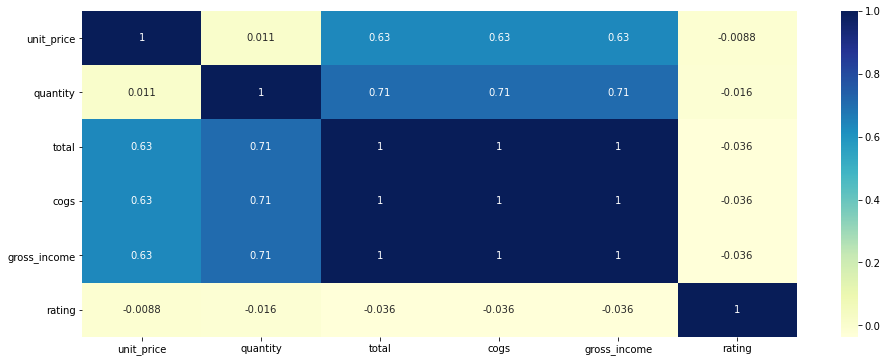

In [25]:
numeric_var = query("""
    SELECT
      unit_price
      , quantity
      , total
      , cogs
      , gross_income
      , rating
      FROM supermarket""")

plt.figure(figsize=(16,6))

sns.heatmap(numeric_var.corr(), cmap="YlGnBu", annot=True)

In [26]:
query("""
      SELECT
      percentile_cont(.33) WITHIN GROUP (ORDER BY unit_price) AS lower_third
      , percentile_cont(.66) WITHIN GROUP (ORDER BY unit_price) AS mid_third
      , percentile_cont(.99) WITHIN GROUP (ORDER BY unit_price) AS upper_third
      FROM supermarket
      """)

,lower_third,mid_third,upper_third
0,39.8505,71.647,99.7102


<AxesSubplot:xlabel='unit_price', ylabel='quantity'>

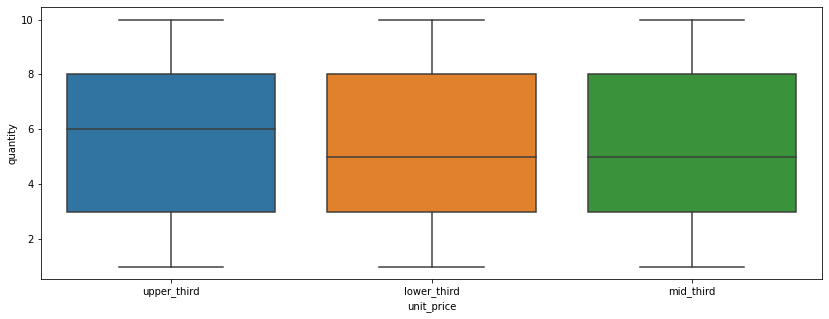

In [27]:
plt.figure(figsize=(14,5))

sns.boxplot(y="quantity", x="unit_price", data=query("""
                                                            SELECT
                                                            CASE
                                                                WHEN unit_price BETWEEN 0 AND 39.8505 THEN 'lower_third'
                                                                WHEN unit_price BETWEEN 39.8505 AND 71.647 THEN 'mid_third'
                                                                WHEN unit_price BETWEEN 71.647 AND 99.7102 THEN 'upper_third'
                                                            END AS unit_price
                                                            -- unit_price
                                                            , quantity
                                                            FROM supermarket
                                                            """))

In [28]:
query("""
                                                            WITH ranked_prices AS(
                                                            SELECT
                                                            CASE
                                                                WHEN unit_price BETWEEN 0 AND 39.8505 THEN 'lower_third'
                                                                WHEN unit_price BETWEEN 39.8505 AND 71.647 THEN 'mid_third'
                                                                WHEN unit_price BETWEEN 71.647 AND 99.7102 THEN 'upper_third'
                                                            END AS unit_price
                                                            -- unit_price
                                                            , quantity
                                                            FROM supermarket
                                                            )
                                                            SELECT
                                                            unit_price
                                                            , AVG(quantity)
                                                            , percentile_cont(.5) WITHIN GROUP (ORDER BY quantity)
                                                            FROM ranked_prices
                                                            GROUP BY unit_price
                                                            """)

,unit_price,avg,percentile_cont
0,lower_third,5.448485,5.0
1,mid_third,5.466667,5.0
2,upper_third,5.609091,6.0
3,None,5.700000,6.0


In [29]:
query("""
      SELECT
      payment
      , AVG(total) AS total_avg
      , STDDEV(total) AS total_stdev
      , percentile_cont(.5) WITHIN GROUP (ORDER BY total) AS total_median
      , percentile_cont(0.05) WITHIN GROUP (ORDER BY total) AS total_5centile
      , percentile_cont(0.95) WITHIN GROUP (ORDER BY total) AS total_95centile
      FROM supermarket
      GROUP BY payment 
      """)

,payment,total_avg,total_stdev,total_median,total_5centile,total_95centile
0,Cash,326.181890,242.660640,262.962,41.40045,816.507825
1,Credit card,324.009878,257.106200,239.589,37.08075,839.669250
2,Ewallet,318.820600,239.305694,253.680,53.45760,803.812800


In [30]:
query("""
      SELECT
      city
      , AVG(total) AS total_avg
      , STDDEV(total) AS total_stdev
      , percentile_cont(.5) WITHIN GROUP (ORDER BY total) AS total_median
      , percentile_cont(0.05) WITHIN GROUP (ORDER BY total) AS total_5centile
      , percentile_cont(0.95) WITHIN GROUP (ORDER BY total) AS total_95centile
      FROM supermarket
      GROUP BY city 
      """)

,city,total_avg,total_stdev,total_median,total_5centile,total_95centile
0,Mandalay,319.872506,242.447565,252.88200,48.40395,802.96020
1,Naypyitaw,337.099715,263.160870,271.41975,32.86710,866.54925
2,Yangon,312.354031,231.640025,240.82800,43.70205,771.82875


In [31]:
query("""
      SELECT
      customer_type
      , AVG(total) AS total_avg
      , STDDEV(total) AS total_stdev
      , percentile_cont(.5) WITHIN GROUP (ORDER BY total) AS total_median
      , percentile_cont(0.05) WITHIN GROUP (ORDER BY total) AS total_5centile
      , percentile_cont(0.95) WITHIN GROUP (ORDER BY total) AS total_95centile
      FROM supermarket
      GROUP BY customer_type 
      """)

,customer_type,total_avg,total_stdev,total_median,total_5centile,total_95centile
0,Member,327.791305,247.993782,266.028,41.454,829.0800
1,Normal,318.122856,243.902800,237.426,40.362,814.6656


In [32]:
query("""
      SELECT
      gender
      , COUNT(*) AS sales_by_gender
      FROM supermarket
      GROUP BY gender
      """)

,gender,sales_by_gender
0,Female,501
1,Male,499


We can see we have only 2 more women than men. The quantity is almost the same between them.

In [33]:
query("""
      SELECT
      MIN(purchase_date)
      , MAX(purchase_date)
      FROM supermarket
      """)

,min,max
0,2019-01-01,2019-03-30


<AxesSubplot:xlabel='purchase_date', ylabel='sum'>

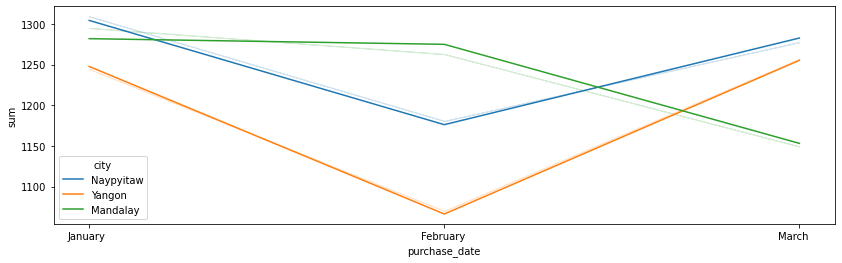

In [34]:
fig, ax = plt.subplots(figsize=(14,4))
sns.lineplot(data=query("""
      SELECT
      TO_CHAR(purchase_date, 'Month') AS purchase_date
      , EXTRACT('Month' FROM purchase_date) AS month
      , city
      , SUM(total)
      FROM supermarket
      GROUP BY purchase_date, city
      ORDER BY month
      """), x="purchase_date", y="sum", hue="city", ci=False)

<AxesSubplot:xlabel='purchase_date', ylabel='sum'>

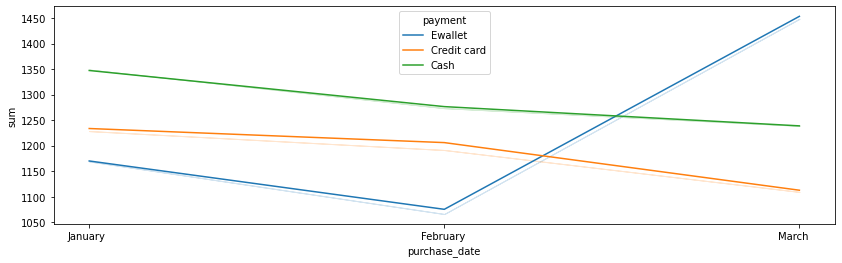

In [35]:
fig, ax = plt.subplots(figsize=(14,4))
sns.lineplot(data=query("""
      SELECT
      TO_CHAR(purchase_date, 'Month') AS purchase_date
      , EXTRACT('Month' FROM purchase_date) AS month
      , payment
      , SUM(total)
      FROM supermarket
      GROUP BY purchase_date, payment, month
      ORDER BY month
      """), x="purchase_date", y="sum", hue="payment", ci=False)

In [36]:
branch = query("""
      SELECT
      branch
      , gender
      , SUM(quantity) AS quantity_sum
      , AVG(quantity)::numeric(3,2) AS quantity_avg
      , PERCENTILE_CONT(.5) WITHIN GROUP (ORDER BY quantity) AS quantity_median
      FROM supermarket
      GROUP BY branch, gender
      """)
branch

,branch,gender,quantity_sum,quantity_avg,quantity_median
0,A,Female,909,5.65,5.0
1,A,Male,950,5.31,5.0
2,B,Female,911,5.62,6.0
3,B,Male,909,5.35,5.0
4,C,Female,1049,5.89,6.0
5,C,Male,782,5.21,5.0


Text(0, 0.5, 'Quantity of products')

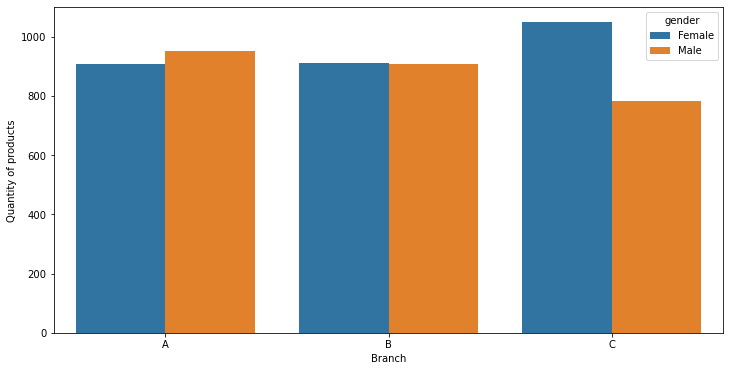

In [37]:
fig, ax = plt.subplots(figsize=(12,6))

ax = sns.barplot(data=branch, y="quantity_sum", x="branch", hue="gender")

ax.set_xlabel("Branch")
ax.set_ylabel("Quantity of products")

In [38]:
c_branch = query("""
                 SELECT
                 gender
                 , customer_type
                 , product_line
                 , SUM(quantity) AS product_count
                 FROM supermarket
                 WHERE branch = 'C'
                 GROUP BY gender, customer_type, product_line
                 ;
                 """)
c_branch

,gender,customer_type,product_line,product_count
0,Male,Normal,Fashion accessories,85
1,Female,Member,Food and beverages,127
2,Female,Normal,Food and beverages,104
3,Male,Normal,Food and beverages,72
4,Female,Member,Fashion accessories,98
5,Female,Normal,Sports and travel,96
6,Male,Member,Sports and travel,57
7,Male,Member,Fashion accessories,65
8,Male,Member,Electronic accessories,59
9,Female,Member,Health and beauty,58


In [39]:
query("""
        WITH males_c AS (
         SELECT
          product_line
          , SUM(quantity) AS product_count
          FROM supermarket
          WHERE branch = 'C' AND gender = 'Male'
          GROUP BY product_line
          ),
          
          females_c AS (
          SELECT
          product_line
          , SUM(quantity) AS product_count
          FROM supermarket
          WHERE branch = 'C' AND gender = 'Female'
          GROUP BY product_line
          )
          
          SELECT
          m.product_line
          , f.product_count AS female_count
          , m.product_count AS male_count
          , f.product_count - m.product_count AS count_diff
          FROM males_c m
          JOIN females_c f
          ON m.product_line = f.product_line
          
      """)

,product_line,female_count,male_count,count_diff
0,Fashion accessories,192,150,42
1,Health and beauty,120,157,-37
2,Electronic accessories,164,169,-5
3,Sports and travel,190,75,115
4,Food and beverages,231,138,93
5,Home and lifestyle,152,93,59


Text(0, 0.5, 'Product quantity')

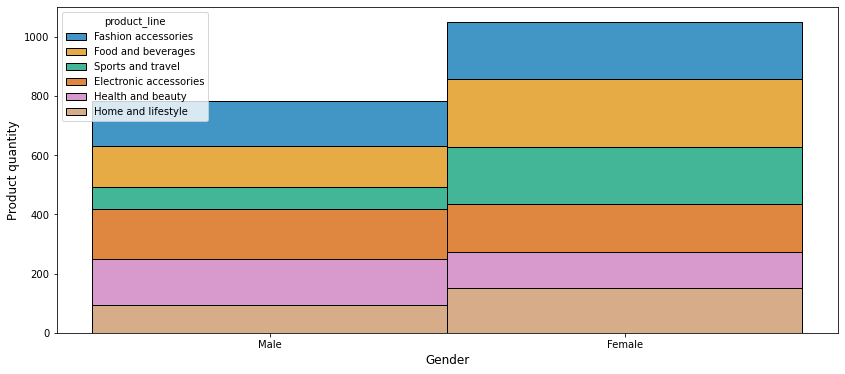

In [40]:
colors = sns.color_palette('colorblind', n_colors=6)
fig, ax = plt.subplots(figsize=(14,6))

ax = sns.histplot(data=c_branch, hue="product_line", 
                  weights="product_count", x="gender", 
                  multiple="stack", palette=colors)

ax.set_xlabel("Gender", size=12)
ax.set_ylabel("Product quantity", size=12)

In [41]:
query("""
      SELECT
      gender
      , product_line
      , AVG(quantity)::numeric(3,2) AS avg_quantity
      , percentile_cont(.5) WITHIN GROUP (ORDER BY quantity) AS median_quantity
      , STDDEV(quantity)::numeric(3,2) AS stdev_quantity
      , percentile_cont(.05) WITHIN GROUP (ORDER BY quantity) AS perctile_05
      , percentile_cont(.95) WITHIN GROUP (ORDER BY quantity) AS perctile_95
      FROM supermarket
      GROUP BY gender, product_line
      """)

,gender,product_line,avg_quantity,median_quantity,stdev_quantity,perctile_05,perctile_95
0,Female,Electronic accessories,5.81,6.0,2.98,1.0,10.0
1,Female,Fashion accessories,5.52,5.0,2.92,1.0,10.0
2,Female,Food and beverages,5.71,5.0,2.92,1.0,10.0
3,Female,Health and beauty,5.36,5.0,2.80,1.0,10.0
4,Female,Home and lifestyle,6.30,6.0,2.78,1.0,10.0
5,Female,Sports and travel,5.64,6.0,2.87,1.0,10.0
6,Male,Electronic accessories,5.62,6.0,2.85,1.0,10.0
7,Male,Fashion accessories,4.54,4.0,3.24,1.0,10.0
8,Male,Food and beverages,5.21,5.0,2.81,1.0,10.0
9,Male,Health and beauty,5.81,6.0,2.88,1.0,10.0
